# Simulating DSA-200 Images

From tyrones_stuff, simulate a very large image, e.g.:

`python sky_model.py --first ~/catalogs/first/first_14dec17.fits -o test_first.fits`

or

`python sky_model.py --first /fastpool/claw/catalogs/first/first_14dec17.fits --agn /fastpool/claw/catalogs/trecs/1sq_deg_sfgs/catalogue_AGNs_complete_1sqdeg.fits --sfg /fastpool/claw/catalogs/trecs/1sq_deg_sfgs/catalogue_SFGs_complete_1sqdeg.fits -o /fastpool/claw/images/dsa2k_first+trecsagnsfg_4096.fits --npix 4096 --target 0 0 1 1`

Details at https://github.com/Radio-Camera-Initiative/tyrones_stuff/blob/main/SURF_2021_Final_Report_v3.pdf.

TODO: add more sources and make larger area. be sure to set npix to produce correct pixel scale

The simulation process will apply image-plane modifications as they are applied by propagation and measurement (going "forward").
1. apply ionospheric screen
2. apply primary beam and cut out 16k x 16k field (~10 sq deg)
3. add noise
4. convolve with PSF

Then iterate over new screens and pointing directions to create a sequence of measurements of a "tile" (e.g., 5x5).

## Setup

In [120]:
import os.path
from scipy.interpolate import RBFInterpolator, CloughTocher2DInterpolator
from multiprocess import Pool
from typing import Literal, Tuple, Union
from astropy.coordinates import SkyCoord
from astropy import units as u
import astropy.wcs as wcs
from astropy.io import fits

import numpy as np
from jax.scipy.signal import convolve
import jax.numpy as jnp
from jaxtyping import Array
import pandas as pd

In [121]:
from data import fits_image
from util import indices, rescale_quantile, gaussian_filter, match_histograms
from interactive import toggle_images, plot_image, sequence_images

In [122]:
def compute_offsets(dxmodel, dymodel):
    # compute each row separately
    def calc_row(r):
        # all indices with row r
        xy =  np.indices((1, IMAGE_SIZE)).squeeze().transpose()  
        xy[:, 0] = r
        row_offsets = np.stack((dxmodel(xy), dymodel(xy)), axis=-1)
        return row_offsets
    
    # Naive multiprocessing (computing each row separately):
    # Note: while this should be extremely parallelizable , something (likely the GIL)
    # is preventing us from achieving optimal performance. This seems to take about 3
    # minutes with multiprocessing (64 cores) and 4.5 minutes without. Thus, Amdahl's
    # law tells us that only about 25% of this task is parallelizable (though it
    # should be closer to 100%).
    def go():
        res = None
        with Pool(processes=CPU_COUNT) as p:
            try:
                res = p.map(calc_row, list(range(IMAGE_SIZE)))
            except:
                p.close()
                import traceback
                raise Exception("".join(traceback.format_exception(*sys.exc_info())))
        return res

    results = go()
    return np.concatenate(results)

def compute_interpolation(interp):
    def g(r):
        xy =  np.indices((1, IMAGE_SIZE)).squeeze().transpose()
        xy[:, 0] = r
        return interp(xy)
    
    # naive multiprocessing, see above
    def go():
        res = None
        with Pool(processes=CPU_COUNT) as p:
            try:
                res = p.map(g, list(range(IMAGE_SIZE)))
            except:
                p.close()
                import traceback
                raise Exception("".join(traceback.format_exception(*sys.exc_info())))
                
        return res

    results = go()
    interp_img = np.stack(results, axis=0)
    return interp_img


In [123]:
def reference_sources_nvss(catalog, min_flux=270) -> Tuple[SkyCoord, Array]:
    nvss = pd.read_csv(catalog, sep=r"\s+")
    sorted_nvss = nvss.sort_values(by=["f"])

    # cut off refernce sources below a certain flux density
    sorted_nvss = sorted_nvss[sorted_nvss["f"] >= min_flux]

    # get coordinates of each reference source
    nvss_orig = sorted_nvss[["rah", "ram", "ras", "dd", "dm", "ds"]].to_numpy()

    # get flux of each reference source in Jy
    fluxes = sorted_nvss[["f"]].to_numpy().squeeze() / 1000

    # manually convert HMS:DMS into degrees
    nvss_ra = (
        15 * nvss_orig[:, 0]
        + (15 / 60) * nvss_orig[:, 1]
        + (15 / 3600) * nvss_orig[:, 2]
    )
    nvss_dec = (
        nvss_orig[:, 3] + (1 / 60) * nvss_orig[:, 4] + (1 / 3600) * nvss_orig[:, 5]
    )

    positions = np.stack((nvss_ra, nvss_dec), axis=-1)

    return SkyCoord(positions, unit=(u.deg, u.deg)), jnp.array(fluxes)

In [124]:
def gkern(l=5, sig=1.0):
    """\
    Creates gaussian kernel with side length `l` and a sigma of `sig`.
    Reaches a maximum of 1 at its center value
    """
    ax = jnp.linspace(-(l - 1) / 2.0, (l - 1) / 2.0, l)
    gauss = jnp.exp(-0.5 * jnp.square(ax) / jnp.square(sig))
    kernel = jnp.outer(gauss, gauss)
    return kernel / kernel.max()

In [125]:
def pbcut(img, center, size):
    """ Multiple by Gaussian primary beam at location center (in (x,y) pixel coords) and width size (pixels).
    """
    pb_kernel = gkern(size, size/4)  # TODO figure out width
    return np.array(img[(center[0]-size//2):(center[0]+size//2), (center[1]-size//2):(center[1]+size//2)]*pb_kernel)

## 1. Iterate over primary beam and cut out

In [126]:
from data import fits_image

In [127]:
# Details on simulation at https://github.com/Radio-Camera-Initiative/tyrones_stuff/blob/main/SURF_2021_Final_Report_v3.pdf
#input_image = '/home/claw/code/tyrones_stuff/test_first_2048.fits'  # toy image at 1350 MHz and FIRST catalog
input_image = '/fastpool/claw/images/dsa2k_first+trecsagnsfg_4096.fits'

In [128]:
image, imwcs = fits_image(input_image)

In [129]:
IMAGE_SIZE = image.shape[0]
CPU_COUNT = 2
WORKING_DIR = '/fastpool/claw/images/'
print(f'Image size: {IMAGE_SIZE}')

Image size: 4096


In [130]:
pixelscale = 1  # arcsec/pixel
width = 512 # arcsec

In [131]:
overwrite = True

fields = {'dsa2k_test_1.fits': (1024, 1024),
          'dsa2k_test_2.fits': (2048, 1024),
          'dsa2k_test_3.fits': (1024, 2048),
          'dsa2k_test_4.fits': (2048, 2048)}

wcss = fields.copy()
w0 = wcs.WCS(naxis=2)
w0.wcs.crpix = [0., 0.]
w0.wcs.cdelt = np.array([-0.0006103515625, 0.0006103515625])
w0.wcs.crval = [0, 0]
w0.wcs.ctype = ["RA---SIN", "DEC--SIN"]

for name, center in fields.items():
    if not overwrite and os.path.exists(os.path.join(WORKING_DIR, name)):
        print(f'not overwriting {name}')
        continue
    output_pbcut = pbcut(image, center, int(width/pixelscale))
#    output_image = np.expand_dims(np.expand_dims(output_pbcut, 0), 0)

    w = w0.copy()
    crpix = [(center[0]-width//2), (center[0]+width//2)]
    w.wcs.crpix = crpix
    hdr = w.to_header()     # TODO: modified wcs to cutout region
    wcss[name] = w
    fits.writeto(f"{os.path.join(WORKING_DIR, name)}", output_pbcut, header=hdr, overwrite=overwrite)

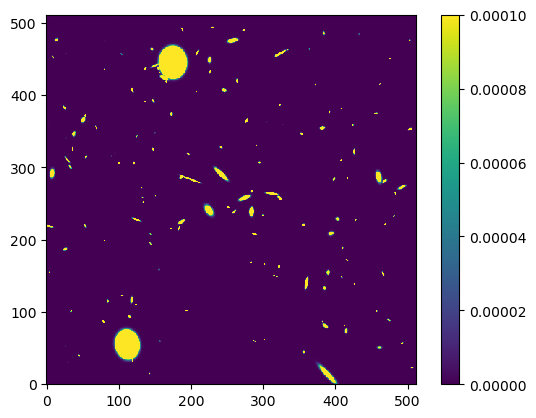

In [138]:
im = fits.open(f"{os.path.join(WORKING_DIR, list(fields.keys())[0])}")[0].data
plot_image(im, vmin=im.min(), vmax=0.0001)

## 2. Ionosphere (one per field)

## fake a warp screen with random ~PSF scale shifts at NVSS positions


In [139]:
catalog = '/fastpool/claw/catalogs/nvss_trim.dat'

In [140]:
positions_xys = {}
for name, w in fields.items():
    print(name)
    hdu = fits.open(f"{os.path.join(WORKING_DIR, name)}")[0]
    w = wcs.WCS(header=hdu.header)
    positions, fluxes = reference_sources_nvss(catalog=catalog)
    positions_xy = jnp.stack(wcs.utils.skycoord_to_pixel(positions, w), axis=1)
    fluxes = fluxes[~jnp.isnan(positions_xy).any(axis=1)]
    positions_xys[name] = positions_xy[~jnp.isnan(positions_xy).any(axis=1)]

dsa2k_test_1.fits
dsa2k_test_2.fits
dsa2k_test_3.fits
dsa2k_test_4.fits


dsa2k_test_1.fits


/home/claw/.conda/envs/py310/lib/python3.10/site-packages/multiprocess/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


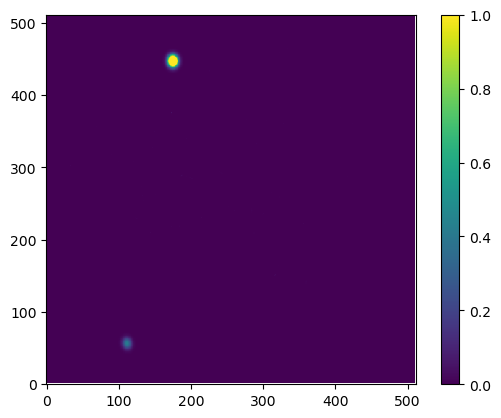

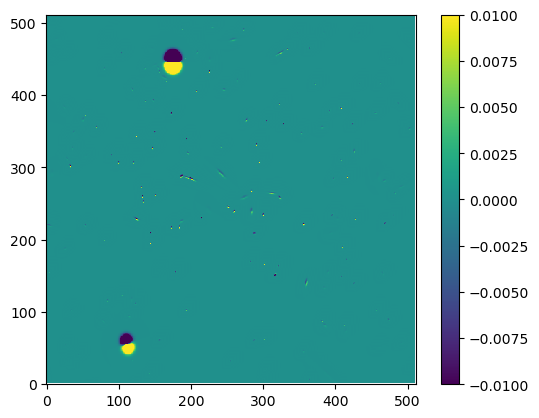

dsa2k_test_2.fits


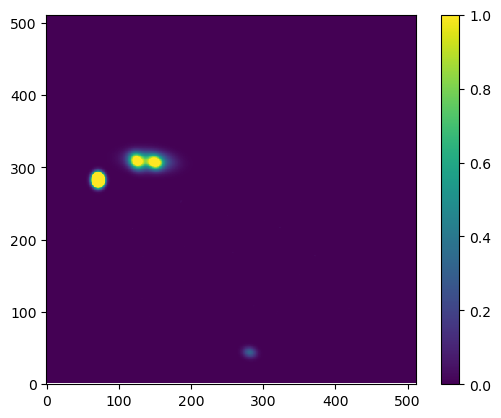

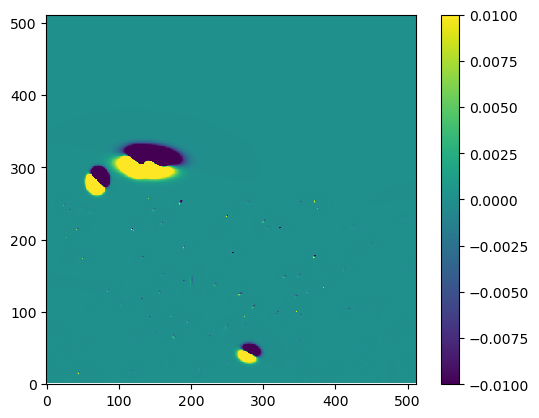

dsa2k_test_3.fits


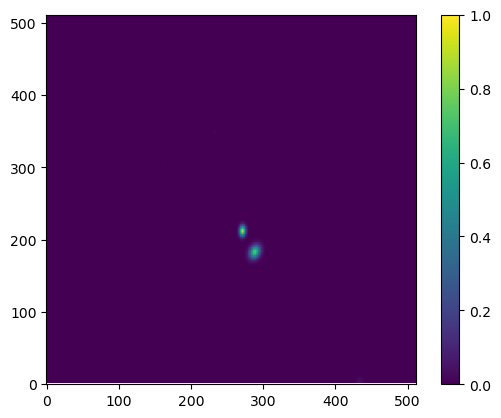

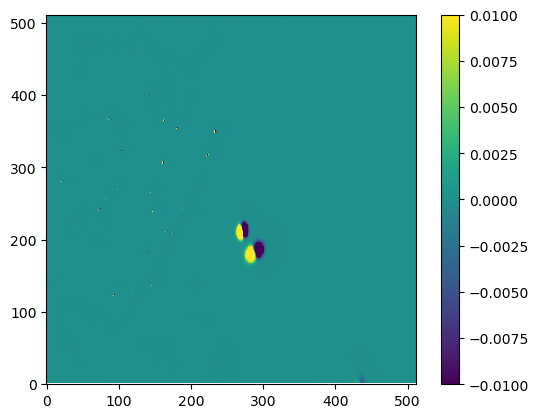

dsa2k_test_4.fits


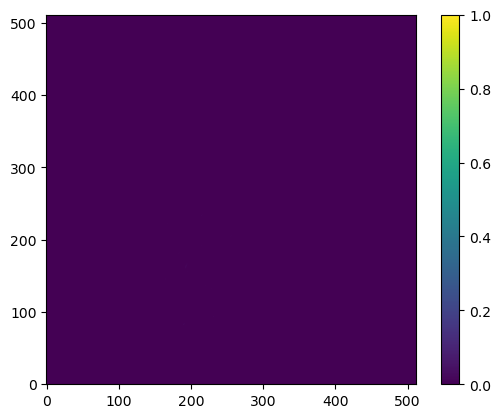

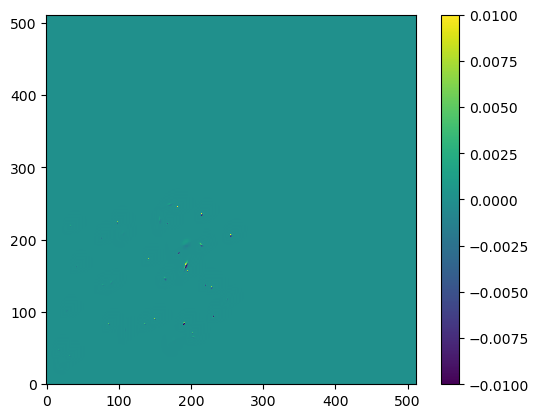

In [141]:
smoothing = 200
neighbors = 3

for name, positions_xy in positions_xys.items():
    print(name)
    if not overwrite and os.path.exists(os.path.join(WORKING_DIR, name.replace('.fits', 'warped.fits'))):
        print('\tskipping', name)
        continue

    hdu = fits.open(f"{os.path.join(WORKING_DIR, name)}")[0]
    image = hdu.data
    hdr = hdu.header
    IMAGE_SIZE = image.shape[0]
    
    # create difference array
    diff = np.random.randint(-2, 3, size=(len(positions_xy), 2))   
    dxmodel = RBFInterpolator(positions_xy, diff[:, 0], kernel='linear', smoothing=smoothing, neighbors=neighbors)
    dymodel = RBFInterpolator(positions_xy, diff[:, 1], kernel='linear', smoothing=smoothing, neighbors=neighbors)

    offsets = compute_offsets(dxmodel, dymodel)  # IMAGE_SIZE^2 x 2
    image_indices = np.indices((IMAGE_SIZE, IMAGE_SIZE)).swapaxes(0, 2)[:, :, ::-1].reshape((IMAGE_SIZE * IMAGE_SIZE, 2))
    interp = CloughTocher2DInterpolator(image_indices - offsets, np.ravel(image))  # very slow
    dewarped = compute_interpolation(interp)  # slow
    output_img = np.expand_dims(np.expand_dims(dewarped, 0), 0)  # if we're writing to FITS with same shape/header
    plot_image(output_img.squeeze(), vmax=1)
    plot_image((image-output_img.squeeze())[:2000,-2000:], vmin=-0.01, vmax=0.01)
    fits.writeto(os.path.join(WORKING_DIR, name.replace('.fits', 'warped.fits')), output_img, header=hdr, overwrite=overwrite)

## 3. Add noise

In [116]:
# TODO: decide whether this is pixel-level random numbers or low-spatial-freq rumble

/fastpool/claw/images/dsa2k_test_1warped.fits


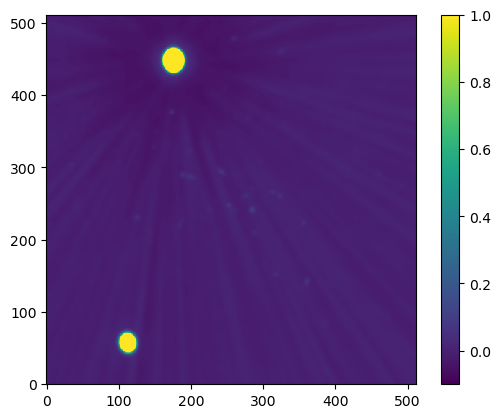

/fastpool/claw/images/dsa2k_test_2warped.fits


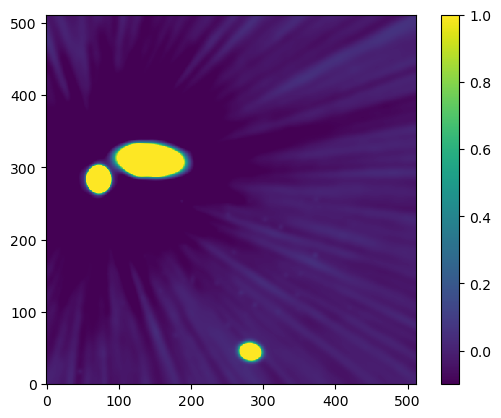

/fastpool/claw/images/dsa2k_test_3warped.fits


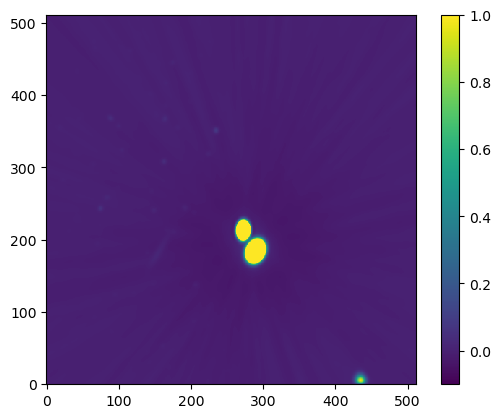

/fastpool/claw/images/dsa2k_test_4warped.fits


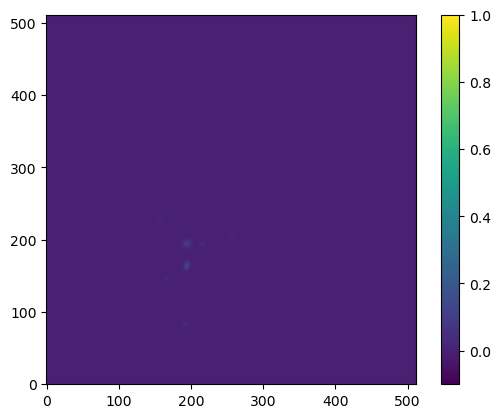

In [142]:
noise_sigma = 2e-6

# TODO: find best PSF
psf_filename = '/fastpool/data/W-GC-8000chan-briggs09-big-psf.fits'
psf_image, psf_wcs = fits_image(psf_filename)

for name, positions_xy in positions_xys.items():
    fn = os.path.join(WORKING_DIR, name.replace('.fits', 'warped.fits'))
    print(fn)
    if os.path.exists(fn):
        hdu = fits.open(fn)[0]
        image = np.ma.masked_invalid(hdu.data.squeeze())
        image.set_fill_value(0)
        hdr = hdu.header
        noise = np.random.normal(0, noise_sigma, size=image.shape)
        image_noise = image.filled()+noise
        convolved = convolve(image_noise, psf_image, mode="same", method="fft")
        plot_image(convolved, vmin=-0.1, vmax=1)

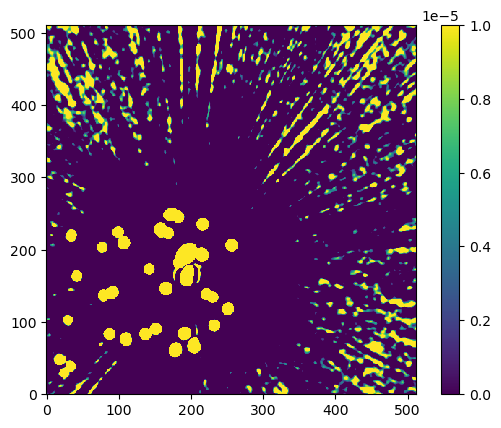

In [147]:
plot_image(convolved, vmax=0.00001)

## 5. (optional) Rescale if it must be normalized to 0-1 range

In [ ]:
# img1r = rescale_quantile(img1, 0.5, 0.95)